### Bulk to single-cell decomposition

Here we explore how we can assemble single-cells to form pseudo-bulk as close as possible to our reference bulk samples.

In [2]:
# Load general Libraries
library(Matrix) ; library(ggplot2) ; library(glmnet)
library(RColorBrewer) ; library(dplyr) ; library(Biobase)
library(IRdisplay) ; library(reshape2) ; library(ggpubr)
library(xbioc) ; library(ComplexHeatmap)
library(SingleCellExperiment) ;  library(ggpmisc)
library(circlize) ; library(MASS)
library(dampack) ; library(rBeta2009) # dampack-rBeta2009 package need to use Dirichlet distribution modelling
library(abind) ; library(DESeq2) ; library(Metrics)# DESeq2 needed for CLIMB deconvolution of expression
# deconvolution methods 
library(MuSiC) ; library(BayesPrism); library(BisqueRNA)
library(climb)

In [3]:
### UPDATE CLIMB ###
#detach("package:climb", unload=TRUE)
#devtools::install_github('alexdray86/climb', force=T)
#library(climb)

### Important functions

In [3]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){ return( sign(cor(pr,tr)) * cor(pr,tr)^2 ) }
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    # per row metrics:
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    # per-column metrics:
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    # overall metrics:
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){
    SStot = sum((tr - mean(tr))^2)
    SSres = sum((pr - tr)^2)
    return(1 - SSres / SStot)
}
r_square <- function(pr, tr){
    return( sign(cor(pr,tr))*cor(pr,tr)^2 )
}
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
} 
### Function for each deconvolution methods ### 
deconvolution_climb_noWeights <- function(sc, bulks, true_prop, celltype_names){
    climb_res = climb(sc, bulks, dwls_weights = F, mode='abundance')
    climb_prop = climb_res$props
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_climb <- function(sc, bulks, true_prop, celltype_names){
    climb_res = climb(sc, bulks, dwls_weights = T, mode='abundance')
    climb_prop = climb_res$props
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_bayesprism <- function(sc, bulks, true_prop, celltype_names){
    myPrism <- new.prism(reference= t(exprs(sc)), 
                         mixture=t(exprs(bulks)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc$cellType), 
                         cell.state.labels = as.character(sc$cellType), 
                         key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
    bp.res <- run.prism(prism = myPrism, n.cores=6)
    bayesprism_prop <- get.fraction (bp=bp.res, which.theta="final",
             state.or.type="type")
    bayesprism_prop = add_missing_celltypes(bayesprism_prop, celltype_names)
    return(as.matrix(bayesprism_prop[,celltype_names]))
}
deconvolution_music <- function(sc, bulks, true_prop, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    music_prop = music.output$Est.prop.weighted
    music_prop = add_missing_celltypes(music_prop, celltype_names)
    return(music_prop[,celltype_names])
}
deconvolution_nnls <- function(sc, bulks, true_prop, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    nnls_prop = music.output$Est.prop.allgene
    nnls_prop = add_missing_celltypes(nnls_prop, celltype_names)
    return(nnls_prop[,celltype_names])
}
deconvolution_bisque <- function(sc, bulks, true_prop, celltype_names){
    bisque.out = BisqueRNA::ReferenceBasedDecomposition(bulks, sc, use.overlap=F)
    bisque_prop = t(bisque.out$bulk.props)
    bisque_prop = add_missing_celltypes(bisque_prop, celltype_names)
    return(bisque_prop[,celltype_names])
}
deconvolution_random <- function(nnls_prop){
    nnls_prop = read.csv(paste0(out_dir, '/nnls_prop.csv'), row.names='X')
    set.seed(1)
    rand_prop = nnls_prop[sample(rownames(nnls_prop)), sample(colnames(nnls_prop))]
    rownames(rand_prop) = rownames(nnls_prop) ; colnames(rand_prop) = colnames(nnls_prop)
    return(rand_prop)
}
write_tables_cibersortx <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    sc_mat = exprs(sc)
    colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    write.table(sc_mat , paste0(tab_dir,"/TMP_cibersortx_sc_mat.txt"), sep = '\t', quote=F)
    write.table(exprs(bulks), paste0(tab_dir,"/TMP_cibersortx_pbulks.txt"), sep = '\t', quote=F)
    # Reformulate to add 'Gene' at the start of the file
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_pbulks.txt > ', 
    #              tab_dir, '/cibersortx_pbulks.txt'))
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_sc_mat.txt > ', 
    #              tab_dir, '/cibersortx_sc_mat.txt'))
    # remove temp files
    #system(paste0('rm ',tab_dir, '/TMP_*'))
}
write_tables_tape_scaden <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # Write all input tables formatted for TAPE / Scaden
    write.csv(t(exprs(bulks)), paste0(tab_dir, "/tape_scaden_bulks_expr.csv"), quote=F)
    sc_mat_TAPE = exprs(sc)
    sc_mat_TAPE = t(sc_mat_TAPE)
    rownames(sc_mat_TAPE) = sc$cellType
    write.csv(sc_mat_TAPE, paste0(tab_dir, "/tape_scaden_scmat_expr.csv"), quote=F)
}
deconvolution_scaden <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING: launching TAPE / Scaden from the command line induces figures popping up
    # which blocks the process (figures have to be closed manually). 
    # To prevent these figures to be made, one can comment lines 103-109,115-119,128-131, 
    # and 172-176 in the file 'tape_scaden_env/lib/python3.7/site-packages/TAPE/utils.py'
    message('Launch Scaden / TAPE deconvolution')
    # Launch bash script that will launch environment and python script
    system(paste0('bash launch_TAPE_and_Scaden.sh ', tab_dir, '/tape_scaden_scmat_expr.csv ',
                  tab_dir, '/tape_scaden_bulks_expr.csv ',
                  '../REVISION_1/data/celltype_expression/TAPE/input/GeneLength.txt ',
                  tab_dir, '/'), wait=TRUE)
}
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    true_p = read.csv(paste0(odir, '/true_prop.csv'), row.names='X')
    sample_names = row.names(true_p)
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')[,colnames(true_p)]
    #climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')[,colnames(true_p)]
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')[,colnames(true_p)]
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')[,colnames(true_p)]
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')[,colnames(true_p)]
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')[,colnames(true_p)]
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')[,colnames(true_p)]
    tape_p = load_tape_prop(tdir, odir, celltype_names)
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='Mixture')[,colnames(true_p)]
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_prop) ; true_prop_rows = rownames(true_prop)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}                                                                                           
make_all_metrics <- function(all_ps, t_prop){
    all_rs = list()
    for(p in 1:length(all_ps)){
        name_p = names(all_ps)[p]
        all_rs[[name_p]] = suppressWarnings(comp_rows_and_cols(all_ps[[p]], t_prop))
    }
    names(all_rs) = names(all_ps)
    return(all_rs)
}
launch_all_deconvolution_methods <- function(sc, bulks, true_prop, celltype_names, out_dir){ 
    # Create folders
    message('Creating folders')
    tmp_dir = paste0(out_dir, '/tmp_tabs')
    dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)
    write.csv(true_prop, paste0(out_dir, '/true_prop.csv'), quote=F)
    write.csv(celltype_names, paste0(out_dir, '/celltype_names.csv'), quote=F)

    ### CLIMB deconvolution ###
    message('CLIMB deconvolution')
    climb_prop = deconvolution_climb(sc, bulks, true_prop, celltype_names)
    write.csv(climb_prop, paste0(out_dir, '/climb_prop.csv'), quote=F)
    message(paste0('CLIMB Accruacy as PCC: ', cor(flatten(true_prop), flatten(climb_prop))))
    
    ### BayesPrism deconvolution ###
    message('BayesPrism deconvolution')
    bayesprism_prop = deconvolution_bayesprism(sc, bulks, true_prop, celltype_names)
    write.csv(bayesprism_prop, paste0(out_dir, '/bayesprism_prop.csv'), quote=F)
    message(paste0('BayesPrism Accruacy as PCC: ', cor(flatten(true_prop), flatten(bayesprism_prop))))
    
    ### MUSIC deconvolution ###
    message('MUSIC deconvolution')
    music_ps = deconvolution_music(sc, bulks, true_prop, celltype_names)
    write.csv(music_ps, paste0(out_dir, '/music_prop.csv'), quote=F)
    message(paste0('MuSiC Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(music_ps)))))
    
    ### NNLS deconvolution ### 
    message('NNLS deconvolution')
    nnls_prop = deconvolution_nnls(sc, bulks, true_prop, celltype_names)
    write.csv(nnls_prop, paste0(out_dir, '/nnls_prop.csv'), quote=F)
    message(paste0('NNLS Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(nnls_prop)))))
    
    ### BisqueRNA deconvolution ### 
    message('BisqueRNA deconvolution')
    bisque_prop = deconvolution_bisque(sc, bulks, true_prop, celltype_names)
    write.csv(bisque_prop, paste0(out_dir, '/bisque_prop.csv'), quote=F)
    message(paste0('BisqueRNA Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(bisque_prop)))))

    ### Deconvolution Scaden / TAPE 
    message('TAPE / Scaden deconvolution')
    write_tables_tape_scaden(sc, bulks, true_prop, celltype_names, tmp_dir)
    deconvolution_scaden(sc, bulks, true_prop, celltype_names, tmp_dir)
    tape_prop = load_tape_prop(tmp_dir, out_dir, celltype_names)
    scaden_prop = load_scaden_prop(tmp_dir, out_dir, celltype_names)
    message(paste0('TAPE prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(tape_prop)))))
    message(paste0('Scaden prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(scaden_prop)))))

    ### Random proportions deconvolution ### 
    message('Random deconvolution')
    rand_prop = deconvolution_random(nnls_prop)
    write.csv(rand_prop, paste0(out_dir, '/rand_prop.csv'), quote=F)
    message(paste0('Random prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(rand_prop)))))
    
    ### CiberSortX deconvolution ### 
    message('Writing tables for CiberSortX')
    write_tables_cibersortx(sc, bulks, true_prop, celltype_names, tmp_dir)
}                                                                                          

## Comparison using pseudo-bulk AML samples 

In [141]:
sc.es =  readRDS("data/pseudobulks_climb/AML_vangalen_sc_es.RDS")
sc.es$cellType = factor(reformat_celltypes(sc.es$cellType_original))
sc.es

ExpressionSet (storageMode: lockedEnvironment)
assayData: 7955 features, 15255 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: AML1012-D0_AAAAAGTTACGT AML1012-D0_AAAACACCAATC ...
    AML997-D0_TAGACCCGCTAT (15255 total)
  varLabels: cellType_original SubjectName cellType_transfered cellType
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [142]:
pbulk.es = readRDS('data/pseudobulks_climb/AML_vangalen_pbulks_vg_labs_es.RDS')
pbulk.es

ExpressionSet (storageMode: lockedEnvironment)
assayData: 7955 features, 16 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: AML1012-D0 AML210A-D0 ... AML997-D0 (16 total)
  varLabels: CTL GMP ... lateEry (19 total)
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [143]:
true_prop = pData(pbulk.es)
colnames(true_prop) = reformat_celltypes(colnames(true_prop))

## Simulate random proportion with dirichlet distribution

We consider that cell-type proportions follow a Dirichlet distribution. To simulate new proportions, we first need to estimate $\alpha$ parameters associated with each cell-types, using mean and standard deviation of cell-type proportions, using ground truth proportions from scRNA-seq as reference.

In [200]:
# Compute mean and standard deviation for each cell-type
p.mean = apply(true_prop, 2, mean)
p.sd = apply(true_prop, 2, sd)
# Estimate alpha parameters using feralaes/dampack library
set.seed(1)
alphas = dirichlet_params(p.mean, p.sd)
alphas = alphas + 1e-4 # add epsilon value tu avoid zero alpha

We can then generate N random proportions using these $\alpha$ parameters estimated from a scRNA-seq. These proportions will then be use to draw randomly C cells and generate N pseudo-bulks.

In [204]:
set.seed(1)
rand_prop = rBeta2009::rdirichlet(n = 200, alphas/2)

Dividing alpha by a constant increase differences between cell-types and increasing it decreases it

In [205]:
colnames(rand_prop) = colnames(true_prop)
rownames(rand_prop) = 1:200

In [206]:
head(rand_prop)

,CTL,GMP,GMPlike,HSC,HSClike,Mono,Monolike,NK,Plasma,ProB,ProMono,ProMonolike,Prog,Proglike,T,cDC,cDClike,earlyEry,lateEry
1,0.0195161904,0.020863855,0.09196142,0.05811869,0.08203892,0.01541876,0.21381720,0.018387750,0.0003733203,2.159172e-03,0.0225131716,0.04385063,0.13407567,0.06720494,0.092535934,0.004522222,0.05898331,0.0352163490,0.01844249
2,0.0036141669,0.058071002,0.02508689,0.11020247,0.09665203,0.01023461,0.12204968,0.049043830,0.0261836051,1.964079e-05,0.0087558442,0.01218269,0.10232459,0.16636300,0.084532503,0.040190804,0.07383782,0.0002055021,0.01044933
3,0.0737722684,0.040582739,0.05611556,0.09364544,0.05906096,0.11203281,0.07124122,0.004878188,0.0001926853,1.779040e-06,0.0088559789,0.02153046,0.04721006,0.17517946,0.171111461,0.002875066,0.05767626,0.0015090001,0.00252861
4,0.0255242839,0.010153687,0.07194717,0.07705837,0.07632718,0.03564605,0.21282494,0.009731051,0.0185276732,4.057074e-03,0.0003410625,0.05877976,0.05985526,0.13248809,0.124366534,0.019249986,0.04578884,0.0054843613,0.01184863
5,0.0009320376,0.012776150,0.10910502,0.05254743,0.07864181,0.02906386,0.17184181,0.007298457,0.0792035911,9.128333e-06,0.0420047271,0.04350095,0.01826453,0.18610339,0.053481260,0.012906419,0.04404710,0.0124464361,0.04582588
6,0.0611156450,0.001323654,0.12357406,0.05339023,0.06474834,0.06486147,0.13719690,0.001885060,0.0094824137,7.436407e-09,0.0177826827,0.09601311,0.08002665,0.17899152,0.007089704,0.014209559,0.06220883,0.0093073667,0.01679280


In [207]:
write.csv(rand_prop, "data/simulation_aml/simulated_prop.csv", quote=F)

In [247]:
rand_prop <- read.csv("data/simulation_aml/simulated_prop.csv", row.names='X')

pdf 
  2

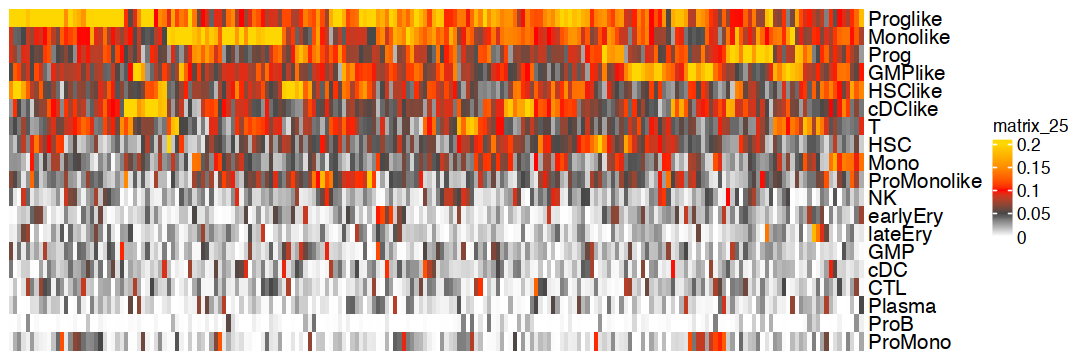

In [208]:
options(repr.plot.width=9, repr.plot.height=3)
col_fun = colorRamp2(c(0, 0.05, 0.1, 0.2), c("white", "grey28", "red", "gold"))
h = Heatmap(t(rand_prop), col=col_fun, cluster_columns=T, show_row_names = T, show_column_names = F, 
            show_row_dend = F, show_column_dend = F)
pdf('results/pseudobulk_analysis/figs/simulation_simulated_props_alphaDiv2.csv', width=9, height=3) ; h ;dev.off()
h

### Simulate drug sensitivity in pseudo-bulk samples 

First, we will strictly use the 16 pseudo-bulk samples that we have, considering from 2 to 21 randomly chosen cell types. The cell-type drug sensitivity will be assume to be the same accross all 16 samples et attributed randomly beforehand. We will then save all these data with metadata and try to predict cell-type drug sensitivity

In [248]:
celltypes = colnames(rand_prop)

Now we will randomly generate "decay factor", that will help us to simulate cell-type drug sensitvity. We will set low decay for most cell types () and high decay for a few ones.

In [249]:
low_decay = c('Monolike', 'Mono', 'ProMonolike')
high_decay = c('HSC', 'HSClike', 'Prog', 'Proglike')
celltype_sensitivity = matrix(0,length(celltypes),7)
decays = list()
set.seed(1)
for(k in 1:length(celltypes)){
    ct = celltypes[k]
    if(ct %in% low_decay){
        decays[[k]] = runif(1,0.7,1.0)
    } else if(ct %in% high_decay) {
        decays[[k]] = runif(1,6.0,8.0)
    } else  {
        decays[[k]] = runif(1,1.2,2.2)
    }
        
    for(d in 1:7){
        celltype_sensitivity[k,d] = 1/(1 + exp(decays[[k]]*d - 8))
    }
}
decays = num(decays)

In [250]:
rownames(celltype_sensitivity) = celltypes
colnames(celltype_sensitivity) = c(1:7)

In [251]:
celltype_sensitivity

,1,2,3,4,5,6,7
CTL,0.9985496,0.9937504874,9.734928e-01,8.945388e-01,6.620530e-01,3.115137e-01,9.461360e-02
GMP,0.9983867,0.9922766382,9.638629e-01,8.470313e-01,5.347888e-01,1.926716e-01,4.720647e-02
GMPlike,0.9980288,0.9885051333,9.359225e-01,7.127108e-01,2.964487e-01,6.678730e-02,1.200952e-02
HSC,0.5457676,0.0004840534,1.951989e-07,7.867762e-11,3.171211e-14,1.278200e-17,5.151963e-21
HSClike,0.8315477,0.0081082837,1.353671e-05,2.241679e-08,3.712170e-11,6.147270e-14,1.017974e-16
Mono,0.9991163,0.9976732797,9.938885e-01,9.840455e-01,9.590038e-01,8.987033e-01,7.708967e-01
Monolike,0.9991039,0.9976079147,9.936302e-01,9.831496e-01,9.561855e-01,8.908628e-01,7.532798e-01
NK,0.9978480,0.9863248361,9.181601e-01,6.357138e-01,2.134944e-01,4.051258e-02,6.524892e-03
Plasma,0.9979150,0.9871537253,9.250244e-01,6.645292e-01,2.412991e-01,4.858275e-02,8.131878e-03
ProB,0.9988166,0.9958331836,9.854376e-01,9.503982e-01,8.443646e-01,6.057023e-01,3.031159e-01


pdf 
  2

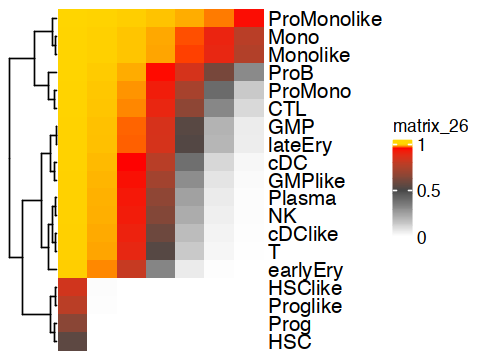

In [212]:
options(repr.plot.width=4, repr.plot.height=3)
col_fun = colorRamp2(c(0, 0.5, 0.95, 1.0), c("white", "grey28", "red", "gold"))
h = Heatmap(celltype_sensitivity, col=col_fun, cluster_columns=F,  show_column_names = F)
pdf("results/pseudobulk_analysis/figs/celltype_sensitivity_alphaDiv2.pdf", width=4, height=3) ; h ;dev.off()
h

We thus simulate a context where HSC-like is resistant to a drug

## Generate bulk drug sensitivity from cell subtype drug sensitivity

In [213]:
all_patients = rownames(rand_prop)
bulk_survivals = list()
tab_ct = rand_prop*5000
set.seed(1)
for(n in 1:length(all_patients)){
    this_patient = rownames(rand_prop)[n]
    celltype_sensitivity_1p = matrix(0,length(celltypes),7)
    tab_ct_1p = tab_ct[n,]
    counts  = tab_ct[n,]
    for(k in 1:length(celltypes)){
        counts_k  = counts[k]
        for(d in 1:7){
            celltype_sensitivity_1p[k,d] = num(round(counts_k*celltype_sensitivity[k,d]))
        }
    }
    rownames(celltype_sensitivity_1p) = celltypes
    colnames(celltype_sensitivity_1p) = c(1:7)
    celltype_sensitivity_1p_n = apply(celltype_sensitivity_1p, 2, function(x) x/tab_ct_1p)
    celltype_sensitivity_1p_n[is.na(celltype_sensitivity_1p_n)] <- 0
    bulk_sensitivity = colSums(celltype_sensitivity_1p) / sum(tab_ct_1p)
    bulk_survivals[[n]] = bulk_sensitivity
}

In [214]:
bulk_drug_sensitivity = do.call(rbind, bulk_survivals)
rownames(bulk_drug_sensitivity) = all_patients
head(bulk_drug_sensitivity)

,1,2,3,4,5,6,7
1,0.8970,0.6538,0.6244,0.5176,0.3718,0.2818,0.2230
2,0.8598,0.5210,0.4948,0.3966,0.2472,0.1604,0.1184
3,0.8910,0.6198,0.5912,0.4828,0.3268,0.2288,0.1720
4,0.9000,0.6500,0.6240,0.5272,0.3880,0.3056,0.2496
5,0.9132,0.6602,0.6334,0.5324,0.3702,0.2638,0.2036
6,0.8956,0.6198,0.6006,0.5298,0.4074,0.3150,0.2544


pdf 
  2

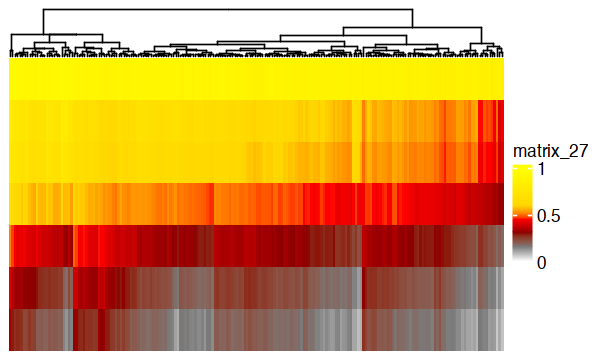

In [215]:
options(repr.plot.width=5, repr.plot.height=3)
col_fun = colorRamp2(c(0.0, 0.15, 0.3, 0.45, 0.6, 1.0), c("white", "grey48", "darkred", "red", "gold","yellow"))
h = Heatmap(t(bulk_drug_sensitivity), col=col_fun, cluster_rows=F, show_row_names = F, show_column_names = F)
pdf("results/pseudobulk_analysis/figs/simulation_bulk_sensitivity_alphaDiv2.pdf", width=5, height=3) ; h ; dev.off()
h

In [216]:
write.csv(bulk_drug_sensitivity, "data/simulation_aml/bulk_drug_sensitivity_alphaDiv2.csv", quote=F)
write.csv(celltype_sensitivity, "data/simulation_aml/celltype_drug_sensitivity_alphaDiv2.csv", quote=F)

## Iterate over all samples to build 200 simulated pseudo-bulks to deconvolve

In [217]:
mean_n_cells = round(mean(table(sc.es$SubjectName)))
sd_n_cells = sd(table(sc.es$SubjectName))

# Estimating parameters of gamma distribution for the total number of cells
set.seed(1)
parms <- fitdistr(table(sc.es$SubjectName), "gamma")

# Generate observation and keep 200 with more than 50 cells
set.seed(1)
gamma_n_cells = rgamma(n = 500, shape = 1, scale = mean_n_cells)
gamma_n_cells <- gamma_n_cells[gamma_n_cells > 50]
gamma_n_cells <- gamma_n_cells[1:200]
gamma_n_cells = round(gamma_n_cells)

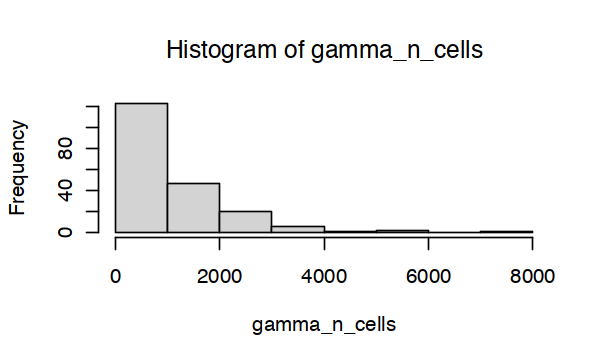

In [218]:
# historgram of the number of cells / sample (from Naldini et al.)
hist(gamma_n_cells)

first we will generate bulk expression samples for 200 simulated data. Single-cell are randomly selected in single-cell from Van Galen et al. , allowing replacement (thus multiple times the same cell). This allows to get simulation possible for cases where not enough cells are available. 

In [222]:
rand_prop = read.csv("data/simulation_aml/simulated_prop_alphaDiv2.csv", row.names = 'X')

In [223]:
rand_prop_m = as.matrix(rand_prop)

In [224]:
### Generation of 200 pseudo-bulk from Naldini's dataset
### Warning: Takes long time to run (~2 hours)
ct_names  = colnames(rand_prop)
all_bulks_wt = list() ; all_ct_props_wt = list()
all_bulks_oe = list() ; all_ct_props_oe = list()
N = dim(rand_prop_m)[1] ; G = dim(sc.es)[1] ; K = dim(rand_prop_m)[2]
S_true_WT = array(rep(0,N*G*K), c(N,G,K))

set.seed(1)
for(n in 1:N){
    display(n)
    n_cells = gamma_n_cells[n] 
    prop_1pat = rand_prop_m[n,]
    idx_rand = list()
    for(k in 1:length(ct_names)){
        ct = ct_names[k]
        this_prop = prop_1pat[k]
        this_n_cells = round(this_prop*n_cells)
        if ( this_n_cells > 0){
            idx_rand[[k]] = sample(grep(paste0("^",ct,"$"), sc.es$cellType), this_n_cells, replace=T)
        } else {
            idx_rand[[k]] = 0
        }
    }
    vec_idx_rand = sort(unlist(idx_rand))
    vec_idx_rand = unique(vec_idx_rand[vec_idx_rand!=0])
    sc.es.sub = sc.es[,vec_idx_rand]

    # Assemble 200 pseudo-bulk for simulation 
    all_bulks_wt[[n]] = rowSums(exprs(sc.es.sub))
    ct_props = table(sc.es.sub$cellType)/sum(table(sc.es.sub$cellType))
    ct_props = ct_props[match(colnames(rand_prop_m), names(ct_props))]
    all_ct_props_wt[[n]] = ct_props
    #ct_expr.agg = aggregate(t(exprs(sc.es.sub)), list(sc.es.sub$cellType), sum, drop=FALSE)
    #rownames(ct_expr.agg) = ct_expr.agg$`Group.1`
    #ct_expr.agg = ct_expr.agg[,-1]
    #ct_expr.agg[is.na(ct_expr.agg)] = 0
    #S_true_WT[n,,] = t(ct_expr.agg)
}

[1] 1

[1] 2

[1] 3

[1] 4

[1] 5

[1] 6

[1] 7

[1] 8

[1] 9

[1] 10

[1] 11

[1] 12

[1] 13

[1] 14

[1] 15

[1] 16

[1] 17

[1] 18

[1] 19

[1] 20

[1] 21

[1] 22

[1] 23

[1] 24

[1] 25

[1] 26

[1] 27

[1] 28

[1] 29

[1] 30

[1] 31

[1] 32

[1] 33

[1] 34

[1] 35

[1] 36

[1] 37

[1] 38

[1] 39

[1] 40

[1] 41

[1] 42

[1] 43

[1] 44

[1] 45

[1] 46

[1] 47

[1] 48

[1] 49

[1] 50

[1] 51

[1] 52

[1] 53

[1] 54

[1] 55

[1] 56

[1] 57

[1] 58

[1] 59

[1] 60

[1] 61

[1] 62

[1] 63

[1] 64

[1] 65

[1] 66

[1] 67

[1] 68

[1] 69

[1] 70

[1] 71

[1] 72

[1] 73

[1] 74

[1] 75

[1] 76

[1] 77

[1] 78

[1] 79

[1] 80

[1] 81

[1] 82

[1] 83

[1] 84

[1] 85

[1] 86

[1] 87

[1] 88

[1] 89

[1] 90

[1] 91

[1] 92

[1] 93

[1] 94

[1] 95

[1] 96

[1] 97

[1] 98

[1] 99

[1] 100

[1] 101

[1] 102

[1] 103

[1] 104

[1] 105

[1] 106

[1] 107

[1] 108

[1] 109

[1] 110

[1] 111

[1] 112

[1] 113

[1] 114

[1] 115

[1] 116

[1] 117

[1] 118

[1] 119

[1] 120

[1] 121

[1] 122

[1] 123

[1] 124

[1] 125

[1] 126

[1] 127

[1] 128

[1] 129

[1] 130

[1] 131

[1] 132

[1] 133

[1] 134

[1] 135

[1] 136

[1] 137

[1] 138

[1] 139

[1] 140

[1] 141

[1] 142

[1] 143

[1] 144

[1] 145

[1] 146

[1] 147

[1] 148

[1] 149

[1] 150

[1] 151

[1] 152

[1] 153

[1] 154

[1] 155

[1] 156

[1] 157

[1] 158

[1] 159

[1] 160

[1] 161

[1] 162

[1] 163

[1] 164

[1] 165

[1] 166

[1] 167

[1] 168

[1] 169

[1] 170

[1] 171

[1] 172

[1] 173

[1] 174

[1] 175

[1] 176

[1] 177

[1] 178

[1] 179

[1] 180

[1] 181

[1] 182

[1] 183

[1] 184

[1] 185

[1] 186

[1] 187

[1] 188

[1] 189

[1] 190

[1] 191

[1] 192

[1] 193

[1] 194

[1] 195

[1] 196

[1] 197

[1] 198

[1] 199

[1] 200

In [225]:
# Create ExpressionSet object for WT context
ct_props = data.frame(t(do.call(cbind,all_ct_props_wt)))
rownames(ct_props) = 1:200
mat_bulks = do.call(cbind,all_bulks_wt)
colnames(mat_bulks) = 1:200
bulk.es = ExpressionSet(mat_bulks)
pData(bulk.es) = ct_props
rownames(bulk.es) = rownames(sc.es)
bulk.es

ExpressionSet (storageMode: lockedEnvironment)
assayData: 7955 features, 200 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: 1 2 ... 200 (200 total)
  varLabels: CTL GMP ... lateEry (19 total)
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [226]:
saveRDS(bulk.es, "data/simulation_aml/sim200_bulk_es_alphaDiv2.RDS")

In [227]:
#saveRDS(S_true_WT, 'data/simulation_aml/sim200_celltype_expression.RDS')

In [297]:
# recover bulk expression from celltype expression:
#bulks_WT = list()
#for(n in 1:200){
#    bulks_WT[[n]] = rowSums(S_true_WT[n,,])
#}
#mat_bulks_WT = do.call(cbind,bulks_WT)
#colnames(mat_bulks_WT) = 1:200
#bulk.wt.es = ExpressionSet(mat_bulks_WT)
#pData(bulk.wt.es) = ct_props
# recover gene names
#rownames(bulk.wt.es) = rownames(sc.es) 
#saveRDS(bulk.wt.es, "data/simulation_aml/sim200_bulk_es.RDS")

## Launch Deconvolution panel

We use Van Galen as a reference single-cell RNA-seq.

In [9]:
sc.es = readRDS("data/pseudobulks_climb/AML_vangalen_sc_es.RDS")
sc.es$cellType = factor(reformat_celltypes(sc.es$cellType))
sc.es

ExpressionSet (storageMode: lockedEnvironment)
assayData: 7955 features, 15255 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: AML1012-D0_AAAAAGTTACGT AML1012-D0_AAAACACCAATC ...
    AML997-D0_TAGACCCGCTAT (15255 total)
  varLabels: cellType_original SubjectName cellType_transfered cellType
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [10]:
celltype_names = reformat_celltypes(levels(sc.es$cellType))
celltype_names

[1] CTL         GMP         GMPlike     HSC         HSClike     Mono       
 [7] Monolike    NK          Plasma      ProB        ProMono     ProMonolike
[13] Prog        Proglike    T           cDC         cDClike     earlyEry   
[19] lateEry    
19 Levels: CTL GMP GMPlike HSC HSClike Mono Monolike NK Plasma ProB ... lateEry

In [11]:
bulk.es = readRDS("data/simulation_aml/sim200_bulk_es.RDS")

In [12]:
true_prop = as.matrix(pData(bulk.es))

In [13]:
colnames(true_prop) = reformat_celltypes(colnames(true_prop))
true_prop = add_missing_celltypes(true_prop, celltype_names)
true_prop = true_prop[,levels(sc.es$cellType)]

In [14]:
all(colnames(true_prop) == levels(sc.es$cellType))

[1] TRUE

In [234]:
out_dir = 'data/simulation_aml/tables_'
launch_all_deconvolution_methods(sc = sc.es, bulks = bulk.es, true_prop = true_prop,
                                 celltype_names = celltype_names, out_dir=out_dir)

Creating folders

CLIMB deconvolution

ABUNDANCE mode: predicting cell-type proportions in bulks

7955 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 

CLIMB Accruacy as PCC: 0.816007846182828

BayesPrism deconvolution



number of cells in each cell state 
cell.state.labels
       ProB     lateEry         CTL     ProMono    earlyEry      Plasma 
         55         172         173         180         213         215 
        cDC         GMP         HSC          NK        Prog        Mono 
        221         242         266         322         326         600 
          T ProMonolike     HSClike     GMPlike     cDClike    Monolike 
        682        1387        1436        1719        1942        2403 
   Proglike 
       2701 
No tumor reference is speficied. Reference cell types are treated equally. 
Number of outlier genes filtered from mixture = 16 
Aligning reference and mixture... 
Nornalizing reference... 
Run Gibbs sampling... 
Current time:  2023-07-25 12:56:34 
Estimated time to complete:  2hrs 20mins 
Estimated finishing time:  2023-07-25 15:15:46 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Update the reference matrix ... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Run Gibbs sampling using updated reference ... 
Current time:  2023-07-25 14:03:09 
Estimated time to complete:  1hrs 54mins 
Estimated finishing time:  2023-07-25 15:56:52 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster


BayesPrism Accruacy as PCC: 0.168943767123961

MUSIC deconvolution

MuSiC Accruacy as PCC: 0.158054056700718

NNLS deconvolution

NNLS Accruacy as PCC: -0.0785166899407346

BisqueRNA deconvolution

Decomposing into 19 cell types.

Using 7955 genes in both bulk and single-cell expression.

Converting single-cell counts to CPM and filtering zero variance genes.

Filtered 0 zero variance genes.

Converting bulk counts to CPM and filtering unexpressed genes.

Filtered 0 unexpressed genes.

Generating single-cell based reference from 15255 cells.


Inferring bulk transformation from single-cell alone.

Applying transformation to bulk samples and decomposing.

BisqueRNA Accruacy as PCC: 0.578313713147601

TAPE / Scaden deconvolution

Launch Scaden / TAPE deconvolution

TAPE prop Accruacy as PCC: 0.751195716954451

Scaden prop Accruacy as PCC: 0.767875295317424

Random deconvolution

Random p

In [15]:
all_props = load_all_props('data/simulation_aml/tables/', include_cibersortx = F)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [16]:
all_res = make_all_metrics(all_props, true_prop)

In [17]:
# Change the Metric by setting type.err to 1, 2, 3, or 4
generate_comp_plot <- function(obj.res, type.err=1){
    #type.err , 1=pcor, 2=scor, 3=r_square, 4=rmse
    type.err.l = list('PCC', 'SCC', 'R2', 'RMSE')
    methods = c('MuSiC', 'NNLS', 'CLIMB', 'TAPE', 'Scaden', 'Bisque', 'Random', 'BayesPrism')#, 'CiberSortX')
    df_scor = data.frame(cbind(obj.res$MuSiC[[type.err]], obj.res$NNLS[[type.err]], 
                               obj.res$CLIMB[[type.err]], obj.res$TAPE[[type.err]], obj.res$Scaden[[type.err]],
                               obj.res$BisqueRNA[[type.err]], obj.res$Random[[type.err]], obj.res$BayesPrism[[type.err]]))#, 
                               #obj.res$CiberSortX[[type.err]]))
    colnames(df_scor) = methods
    levels_ = colnames(df_scor)[rev(order(colMeans(as.matrix(df_scor), na.rm = T)))]
    if(type.err.l[[type.err]] == 'RMSE'){levels_ = rev(levels_)}
    df_scor_m = reshape2::melt(df_scor)
    df_scor_m$variable = factor(df_scor_m$variable, levels = levels_) 
    g_rows = ggplot(df_scor_m) + geom_boxplot(aes(x=variable, y=value, color=variable), outlier.shape = NA) + theme_classic() +
                geom_jitter(aes(x=variable, y=value, color=variable)) + theme_classic() +
                scale_color_manual(values=ifelse(grepl('CLIMB', levels_), 'darkred', 'grey38')) + 
                theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
                xlab('') + ylab(type.err.l[type.err]) #+ coord_flip() # ylab(expression(pa
    return(g_rows)
}

In [18]:
# type.err parameter: 1=pcor, 2=scor, 3=r_square, 4=rmse 
g_pcc = generate_comp_plot(all_res, type.err=1) # PCC
g_scc = generate_comp_plot(all_res, type.err=2) # SCC
g_r2 = generate_comp_plot(all_res, type.err=3) # R-square
g_rmse = generate_comp_plot(all_res, type.err=4) # RMSE

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



pdf 
  2

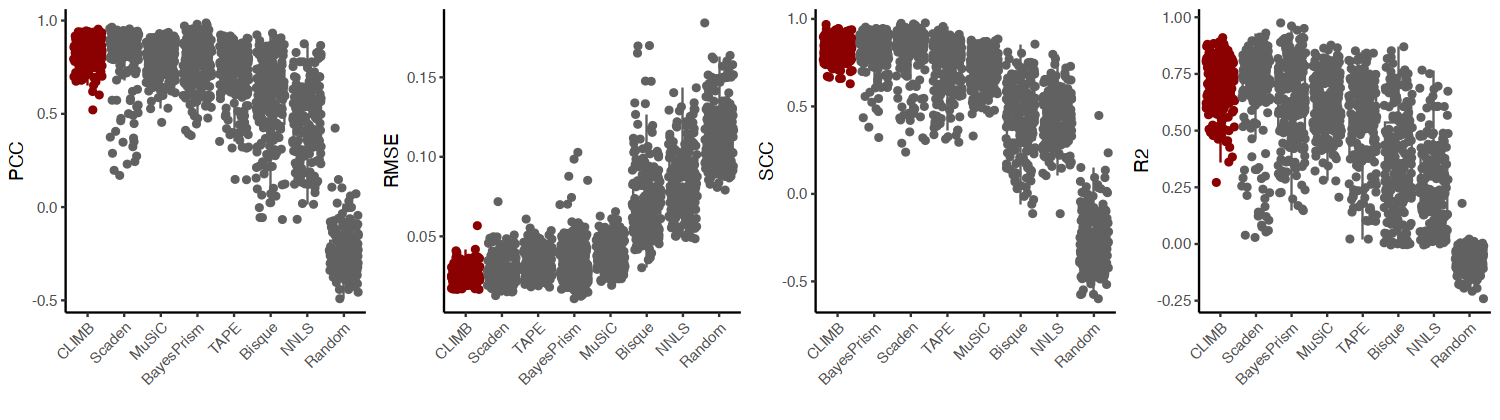

In [27]:
options(repr.plot.width=12.5, repr.plot.height=3.5)
g <- ggarrange(g_pcc, g_rmse, g_scc, g_r2, ncol=4, nrow=1)
pdf('results/fig3/boxplot_psample_4metrics_sim200.pdf', width=12.5, height=3.5) ; g ; dev.off()
g

In [21]:
df_scatter = cbind(melt(all_props$CLIMB), melt(true_prop),melt(all_props$Scaden))

In [22]:
df_scatter = df_scatter[,c(2,3,6,9)]
colnames(df_scatter) = c('celltype', 'climb', 'true', 'cibersortx')

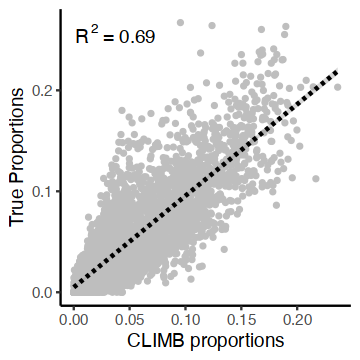

In [26]:
options(repr.plot.width=3, repr.plot.height=3)
g <- ggplot(df_scatter, aes(x=climb, y=true)) + geom_point(color='grey',size=1) + 
    theme_classic() + xlab('CLIMB proportions') + ylab('True Proportions') + 
    stat_poly_line(color='black', linetype='dashed') +  stat_poly_eq()
#pdf('results/fig3/scatter_climb_sim200.pdf', width=3, height=3) ; g ; dev.off()
g